<a href="https://colab.research.google.com/github/psfleury/Data_Science_Projects/blob/main/TCC_Pos_ASPS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
import nltk
nltk.download('stopwords')
nltk.download('rslp')
from nltk.stem import SnowballStemmer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
import sklearn.feature_extraction.text as text
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm, tree, neighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


In [55]:
# Importando o dataset a ser utilizado, com as dimensões de interesse
col_list = ['dt_AnoEmpenho','cd_Ugestora','de_TipoRecursos','de_Historico', 'tp_Operacao'] 
df = pd.read_csv('https://raw.githubusercontent.com/psfleury/Data_Science_Projects/main/3%20-%20ASPS/Empenhos_ASPS_2012_a_2018.txt', sep='|', usecols=col_list)

In [56]:
df.shape

(53255, 5)

In [57]:
# Avaliar os valores nulos
(df.isnull().sum() * 100  / df.shape[0]).sort_values(ascending=False)

de_Historico       0.009389
dt_AnoEmpenho      0.000000
tp_Operacao        0.000000
de_TipoRecursos    0.000000
cd_Ugestora        0.000000
dtype: float64

In [58]:
# Tendo em vista que o campo "de_Historico" possui baixíssima quantidade de valores nulos, tais registros serão retirados da base
df.dropna(inplace=True)

In [59]:
# Confirmando que apenas 5 registros foram excluídos
df.shape

(53250, 5)

In [60]:
df.head()

,cd_Ugestora,de_TipoRecursos,tp_Operacao,dt_AnoEmpenho,de_Historico
1,201039,Receita de Impostos e de Transferência de Impo...,E,2017,aquisição de pilhas para a Secretaria de Saúd...
2,201039,Receita de Impostos e de Transferência de Impo...,E,2017,"guias de recolhimento do INSS empresa (Saude),..."
3,201039,Receita de Impostos e de Transferência de Impo...,E,2017,"guias de recolhimento do INSS empresa (saúde),..."
4,201039,Receita de Impostos e de Transferência de Impo...,E,2017,ajuda financeira para tratamento de saúde do ...
5,201039,Receita de Impostos e de Transferência de Impo...,E,2017,ajuda financeira para tratamento de saúde do f...


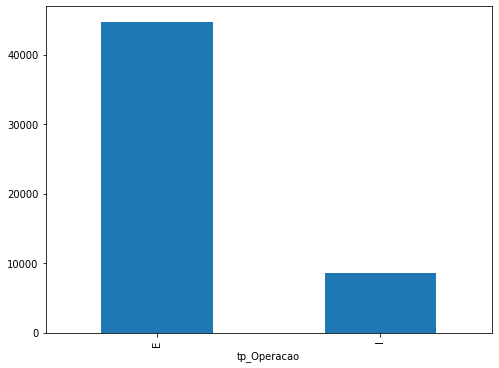

In [61]:
# São duas classes: "E" e "I". Nesse caso, importante ver se elas estão balanceadas no dataset
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('tp_Operacao').de_Historico.count().plot.bar(ylim=0)
plt.show()

In [62]:
# Converter todas os caracteres do campo de_Historico em letras minúsculas
df['de_Historico'] = df['de_Historico'].apply(lambda x: " ".join(x.lower() for x in x.split()))

In [63]:
df.head()

,cd_Ugestora,de_TipoRecursos,tp_Operacao,dt_AnoEmpenho,de_Historico
1,201039,Receita de Impostos e de Transferência de Impo...,E,2017,aquisição de pilhas para a secretaria de saúde...
2,201039,Receita de Impostos e de Transferência de Impo...,E,2017,"guias de recolhimento do inss empresa (saude),..."
3,201039,Receita de Impostos e de Transferência de Impo...,E,2017,"guias de recolhimento do inss empresa (saúde),..."
4,201039,Receita de Impostos e de Transferência de Impo...,E,2017,ajuda financeira para tratamento de saúde do s...
5,201039,Receita de Impostos e de Transferência de Impo...,E,2017,ajuda financeira para tratamento de saúde do f...


In [64]:
# armazenando stopwords da língua portuguesa obtidas no pacote nltk para uma lista
stop = stopwords.words('portuguese')

In [65]:
# retirando as stopwords da descrição dos empenhos
df['de_Historico'] = df['de_Historico'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

In [66]:
df.head()

,cd_Ugestora,de_TipoRecursos,tp_Operacao,dt_AnoEmpenho,de_Historico
1,201039,Receita de Impostos e de Transferência de Impo...,E,2017,aquisição pilhas secretaria saúde deste municipio
2,201039,Receita de Impostos e de Transferência de Impo...,E,2017,"guias recolhimento inss empresa (saude), relat..."
3,201039,Receita de Impostos e de Transferência de Impo...,E,2017,"guias recolhimento inss empresa (saúde), relat..."
4,201039,Receita de Impostos e de Transferência de Impo...,E,2017,ajuda financeira tratamento saúde sr. gilvan s...
5,201039,Receita de Impostos e de Transferência de Impo...,E,2017,ajuda financeira tratamento saúde filho sra el...


In [67]:
# Faz o stemming para tirar prefixos e sufixos
stemmer = nltk.stem.RSLPStemmer()
df['de_Historico'] = df['de_Historico'].apply(lambda x: " ".join([stemmer.stem(word) for word in x.split()]))

In [68]:
df.head()

,cd_Ugestora,de_TipoRecursos,tp_Operacao,dt_AnoEmpenho,de_Historico
1,201039,Receita de Impostos e de Transferência de Impo...,E,2017,aquis pilh secret saúd dest municipi
2,201039,Receita de Impostos e de Transferência de Impo...,E,2017,"gui recolh ins empr (saude), relat compet 11/2..."
3,201039,Receita de Impostos e de Transferência de Impo...,E,2017,"gui recolh ins empr (saúde), relat compet 11/2..."
4,201039,Receita de Impostos e de Transferência de Impo...,E,2017,"ajud financ trat saúd sr. gilvan so monteiro, ..."
5,201039,Receita de Impostos e de Transferência de Impo...,E,2017,ajud financ trat saúd filh sra elane queiroz a...


In [112]:
# separa as bases de treino e teste
features = df[["cd_Ugestora","de_TipoRecursos","dt_AnoEmpenho","de_Historico"]]
label = df['tp_Operacao']


In [113]:
# Prepara transformação das features e labels
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
encoder_cat = preprocessing.LabelEncoder()
column_transformer = ColumnTransformer([('term', tfidf_vect, 'de_Historico'), ('tnf2', OneHotEncoder(dtype='int'), ['dt_AnoEmpenho']), ('fontes', OneHotEncoder(dtype='int'), ['de_TipoRecursos']), ('cd_ug', OneHotEncoder(dtype='int'), ['cd_Ugestora'])],remainder='passthrough')

In [123]:
features_posp = column_transformer.fit_transform(features)
label_posp = encoder_cat.fit_transform(label)

In [125]:
xtrain_pos, xvalid_pos, ytrain_pos, yvalid_pos = model_selection.train_test_split(features_posp, label_posp)

In [126]:
print(np.shape(xtrain_pos))
print(np.shape(xvalid_pos))
print(np.shape(ytrain_pos))
print(np.shape(yvalid_pos))

(39937, 5253)
(13313, 5253)
(39937,)
(13313,)


In [127]:
# Função padrão para treinamento de qualquer modelo
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
  # fit the training dataset on the classifier
  classifier.fit(feature_vector_train, label)
  # predict the labels on validation dataset
  predictions = classifier.predict(feature_vector_valid)
  return metrics.accuracy_score(predictions, yvalid_pos)

In [128]:
# Identificando melhor alpha para naive bayes, armazenando a acurácia de acordo com cada valor de alpha em um dicionário
resultados_bayes = {}
for i in range(0, 1000, 25):
  accuracy = train_model(naive_bayes.MultinomialNB(alpha=i/1000), xtrain_pos, ytrain_pos, xvalid_pos)
  resultados_bayes[i/1000] = accuracy

/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:557: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  % _ALPHA_MIN


In [129]:
# armazena o valor de alpha que maximiza a acurácia de naive bayes
alpha_bayes = list(resultados_bayes.keys())[list(resultados_bayes.values()).index(max(resultados_bayes.values()))]
print(list(resultados_bayes.keys())[list(resultados_bayes.values()).index(max(resultados_bayes.values()))])  

0.75


In [ ]:
# Identificando melhor valor de n para ser utilizado no modelo de vizinhos mais próximos
resultados_knn = {}
for i in range(1, 20, 1):
  accuracy = train_model(neighbors.KNeighborsClassifier(n_neighbors=i), xtrain_pos, ytrain_pos, xvalid_pos)
  resultados_knn[i] = accuracy

# armazena o valor de alpha que maximiza a acurácia de naive bayes
n_knn = list(resultados_knn.keys())[list(resultados_knn.values()).index(max(resultados_knn.values()))]
print(list(resultados_knn.keys())[list(resultados_knn.values()).index(max(resultados_knn.values()))])  

1


In [117]:
# Treinamento do modelo Naive Bayes
accuracy = train_model(naive_bayes.MultinomialNB(alpha=0.025), xtrain_pos, ytrain_pos, xvalid_pos)
print ("Accuracy: ", accuracy)

ValueError: ignored

In [ ]:
# Treinamento com Regressão logística
accuracy = train_model(linear_model.LogisticRegression(), xtrain_pos, ytrain_pos, xvalid_pos)
print ("Accuracy: ", accuracy)

Accuracy:  0.9648463907458875


In [ ]:
# Treinamento com Vizinhos mais próximos
accuracy = train_model(neighbors.KNeighborsClassifier(n_neighbors=1), xtrain_pos, ytrain_pos, xvalid_pos)
print ("Accuracy: ", accuracy)

Accuracy:  0.9809209043791782


In [ ]:
# Treinamento com SVM
accuracy = train_model(svm.SVC(), xtrain_tfidf, train_y, xvalid_tfidf)
print ("Accuracy: ", accuracy)

Accuracy:  0.985502891910163


In [118]:
# Treinamento com Árvore de decisão
accuracy = train_model(tree.DecisionTreeClassifier(), xtrain_pos, ytrain_pos, xvalid_pos)
print ("Accuracy: ", accuracy)

ValueError: ignored

In [ ]:
# Treinamento com Random Forest
accuracy = train_model(RandomForestClassifier(), xtrain_pos, ytrain_pos, xvalid_pos)
print ("Accuracy: ", accuracy)

Accuracy:  0.9819725080748141
